# Imports

Install `requirements.txt` first.

In [1]:
import getspan

import scanpy as sc
import pandas as pd
import numpy as np
import palantir

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# set seed
np.random.seed(5)

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


# Plot parameters

In [2]:
sc.set_figure_params(scanpy=False, frameon=False, transparent=False, format='png')

In [3]:
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['image.cmap'] = 'Spectral_r'


# Functions

In [4]:
from joblib import Parallel, delayed
from scipy.sparse import hstack, csr_matrix, issparse
import gc

def _dot_func(x, y):
    return x.dot(y)

def impute_data(dm_res, ad, n_steps=3):
    T_steps = dm_res['T'] ** n_steps
    T_steps = T_steps.astype(np.float32)

    # Run in parallel
    seq = np.append(np.arange(0, ad.X.shape[1], 100), [ad.X.shape[1]])
    res = Parallel(n_jobs=-1)(delayed(_dot_func)(T_steps, ad.X[:, seq[i - 1]:seq[i]]) for i in range(1, len(seq)))
    imputed_data = hstack(res)
    imputed_data = imputed_data.todense()
    imputed_data[imputed_data < 1e-2] = 0
    gc.collect()

    return imputed_data

# Loading Data

* A sample dataset containing counts from endoderm cells can be found at `settylab/getspan/data/sample_endoderm_counts.csv.gz`
    * The counts have already been normalized and log transformed
    * The metadata for the data is at `settylab/getspan/data/metadata.csv.gz`
* Getspan assumes that the pseudo-axis has already been precomputed. In the metadata file, each cell has a value on a previously computed pseudo anterior-posterior axis

*Note:* in the below cell, file paths may be different

In [6]:
metadata = pd.read_csv('../data/metadata.csv.gz', index_col=0)
adata = sc.read('../data/sample_endoderm_counts.csv.gz')

In [7]:
adata.obs = metadata
adata.X = csr_matrix(adata.X)

In [8]:
adata

AnnData object with n_obs × n_vars = 2648 × 17969
    obs: 'n_counts', 'leiden', 'DoubletScores', 'CellType', 'log_n_counts', 'ap_dist'

# Preprocessing
The counts here are already normalized and log transformed

## Highly variable gene selection

In [9]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=2000)

## PCA

In [10]:
sc.pp.pca(adata, use_highly_variable=True, n_comps=50)

## Neighbor graph and umap

In [11]:
sc.pp.neighbors(adata, use_rep='X_pca')

In [12]:
sc.tl.umap(adata)
sc.tl.leiden(adata)

/home/cdien/.conda/envs/getspan/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CellType' as categorical


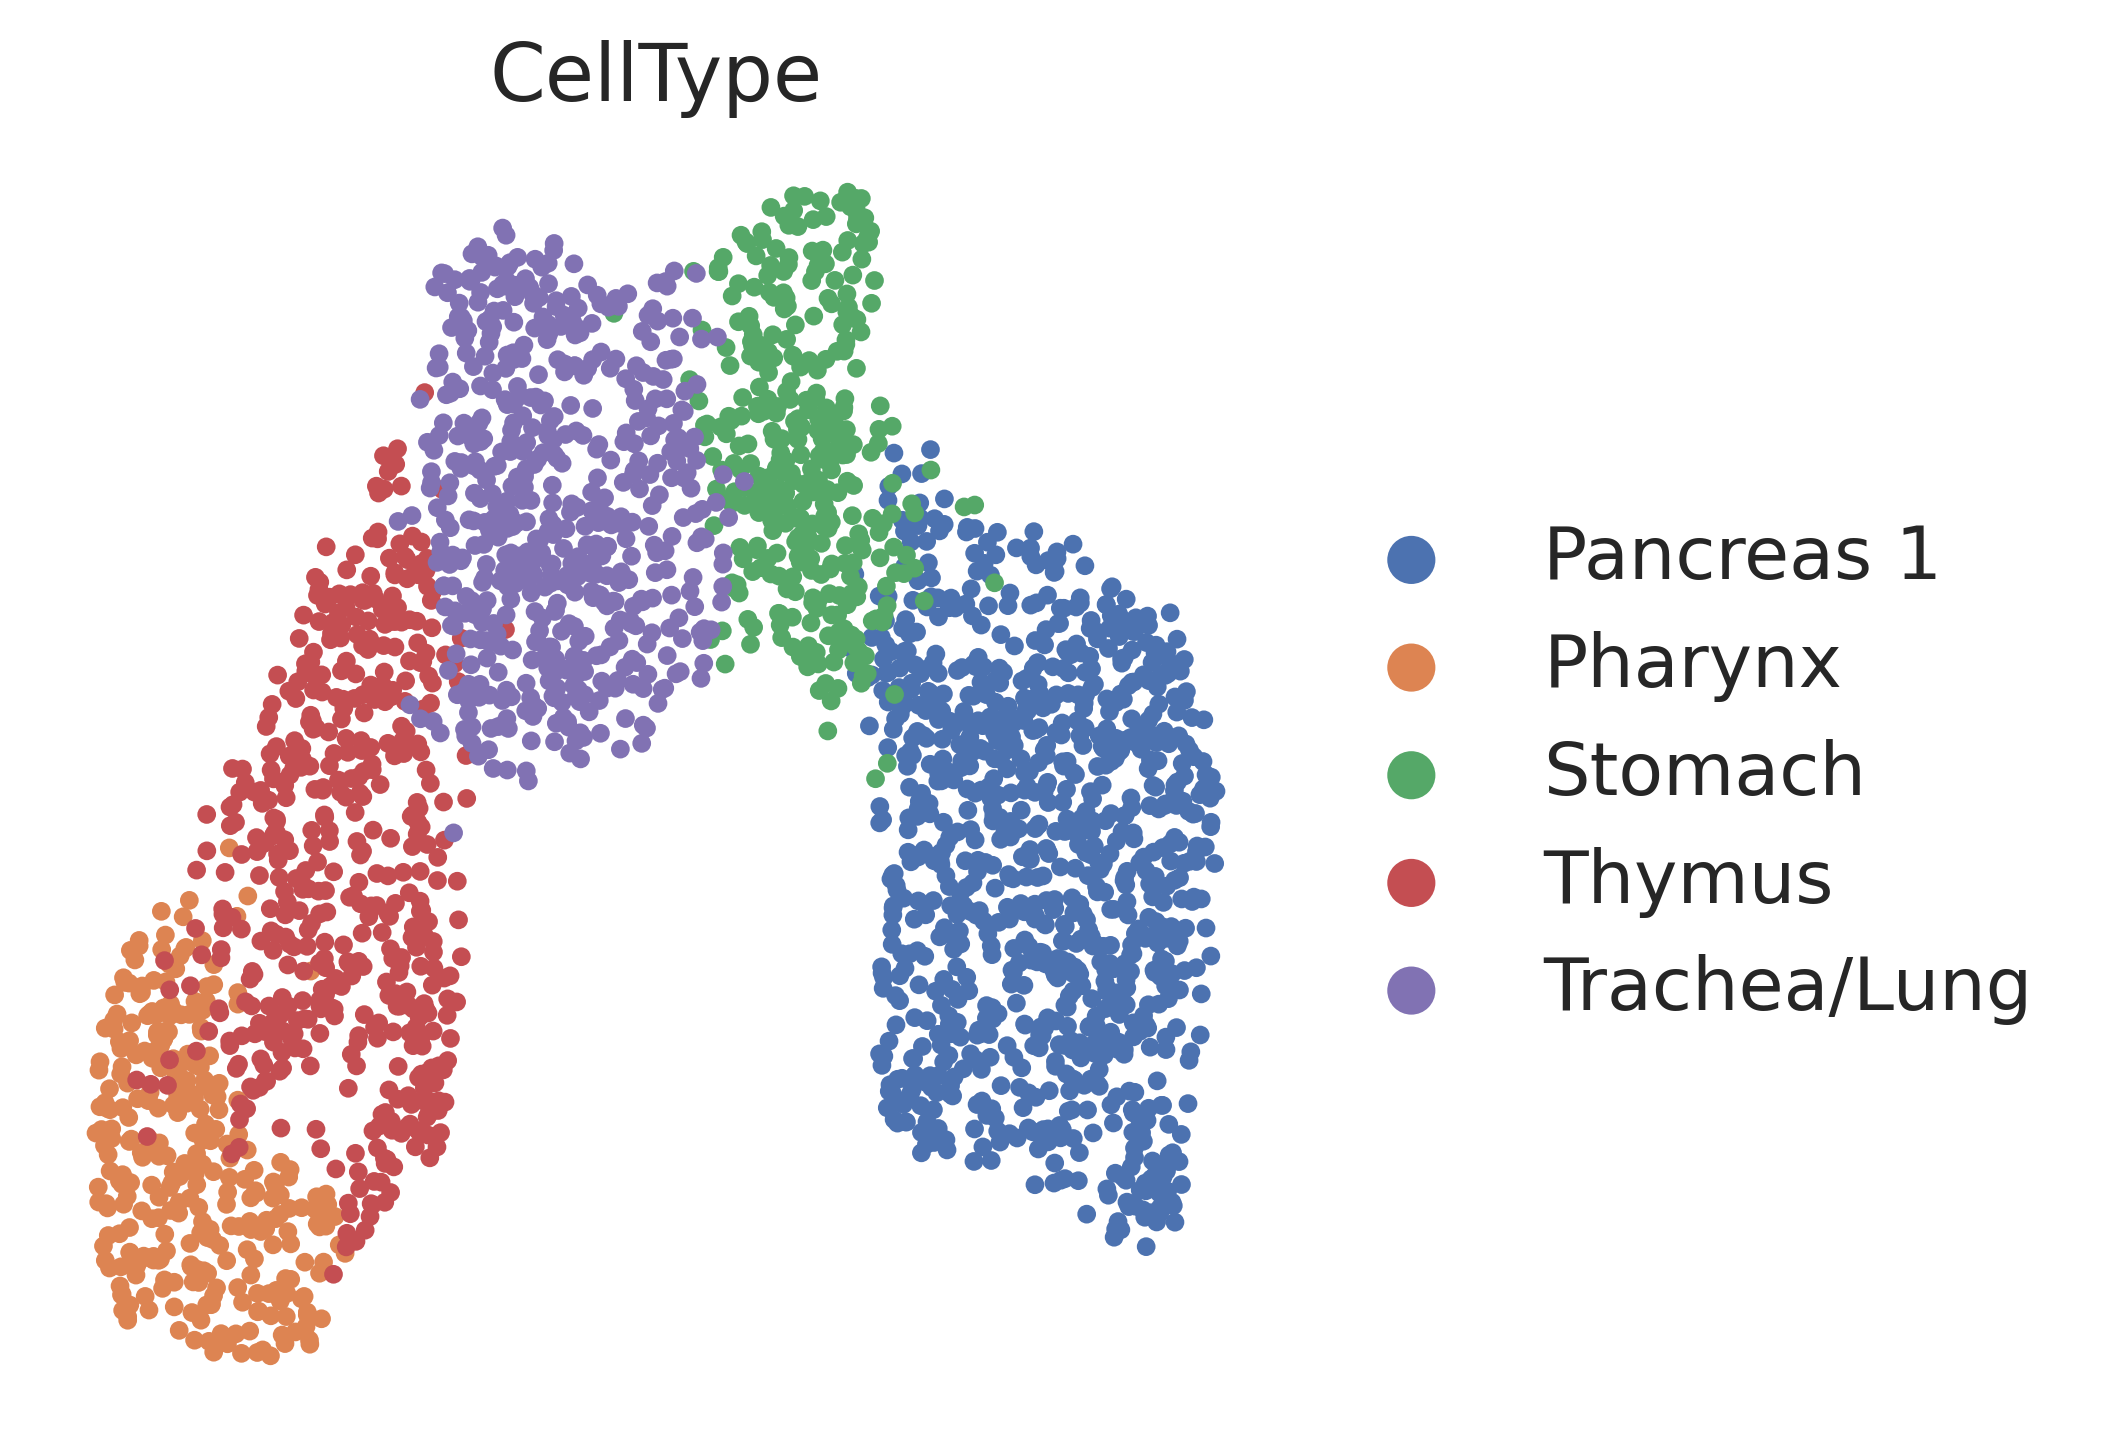

In [13]:
sc.pl.scatter(adata, basis='umap', color='CellType', frameon=False)

## Calculate diffusion components

In [14]:
dm_res = palantir.utils.run_diffusion_maps(pd.DataFrame(adata.obsm['X_pca'], index=adata.obs_names))

Determing nearest neighbor graph...


## Impute gene expression

In [15]:
adata.obsm['MAGIC_imputed_data'] = impute_data(dm_res, adata)

In [16]:
imputed_df = pd.DataFrame(adata.obsm['MAGIC_imputed_data'], columns=adata.var_names, index=adata.obs_names)

In [18]:
adata

AnnData object with n_obs × n_vars = 2648 × 17969
    obs: 'n_counts', 'leiden', 'DoubletScores', 'CellType', 'log_n_counts', 'ap_dist'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'CellType_colors'
    obsm: 'X_pca', 'X_umap', 'MAGIC_imputed_data'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Running getspan

Since calculating the regression line that the gene spans are computed can have high CPU time, especially when calculating trends for a large number of genes, it is recommended to:

* use a machine with ~32 cores
* calculate trends and spans for a gene set of interest

**Note** If you are calculating trends for gene sets >150, it would be wise to set `save=True` and pass a file path to save the output to a `.pickle` file

In [17]:
# sample test set
gene_set = ['Pax8', 'Isl1', 'Prrx2','Irx3',
            'Hoxb1',  'Gata6', 'Foxa3', 'Hoxc8']

## Calculating gene trends with Gaussian Process Regression (GPR):

In order to calculate the span on a gene's expression along the pseudo-axis, we first need to calculate a regression line fitted to the imputed gene expresion (stored in `adata.obsm['MAGIC_imputed_data']`). This is because the single cell data can be very noisy and a regression line allows us to more cleanly define the region where/when a gene is expressed.

A couple of things to note:

* with a smoother regression line (one with fewer concavities), getting a more accurate span is more likely. This is for the same reason we compute a regression line in the first place

* computing a tighter fitting regression can still be nice for later visualzation. For this reason it is recommened to compute both a smooth and non-smooth GPR (controlled with the `smooth` parameter)
    * Note: A non-smooth GPR is more computationally intensive

In [19]:
gene_trends = getspan.span.calc_reg(adata, gene_set,'ap_dist',data_key='MAGIC_imputed_data', save=True, pickle_file='tutorial.pickle')
# example of saving to a .pickle file. Specify full path or it will save in the working directory

GPR:   0%|          | 0/8 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   49.7s remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   59.6s remaining:   35.8s


time to finish:1.1262195150057475 minutes


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  1.1min finished


In [20]:
smooth_gene_trends = getspan.span.calc_reg(adata, gene_set, 'ap_dist', smooth=True)

GPR:   0%|          | 0/8 [00:00<?, ?it/s]

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   32.1s remaining:   53.5s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   34.9s remaining:   20.9s


time to finish:0.6190956115722657 minutes


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   37.1s finished


### Visualizing gene trends

getspan's `.plot` module contains a flexible `plot_reg` function that allows the visualization of the computed GPR trend. Below you will find a few examples of the type of plots you can make

#### With normalized values

To plot the trend lines between 0 and 1, we should first normalize the values:

In [21]:
norm_trend = getspan.span.normalize_regs(gene_trends)


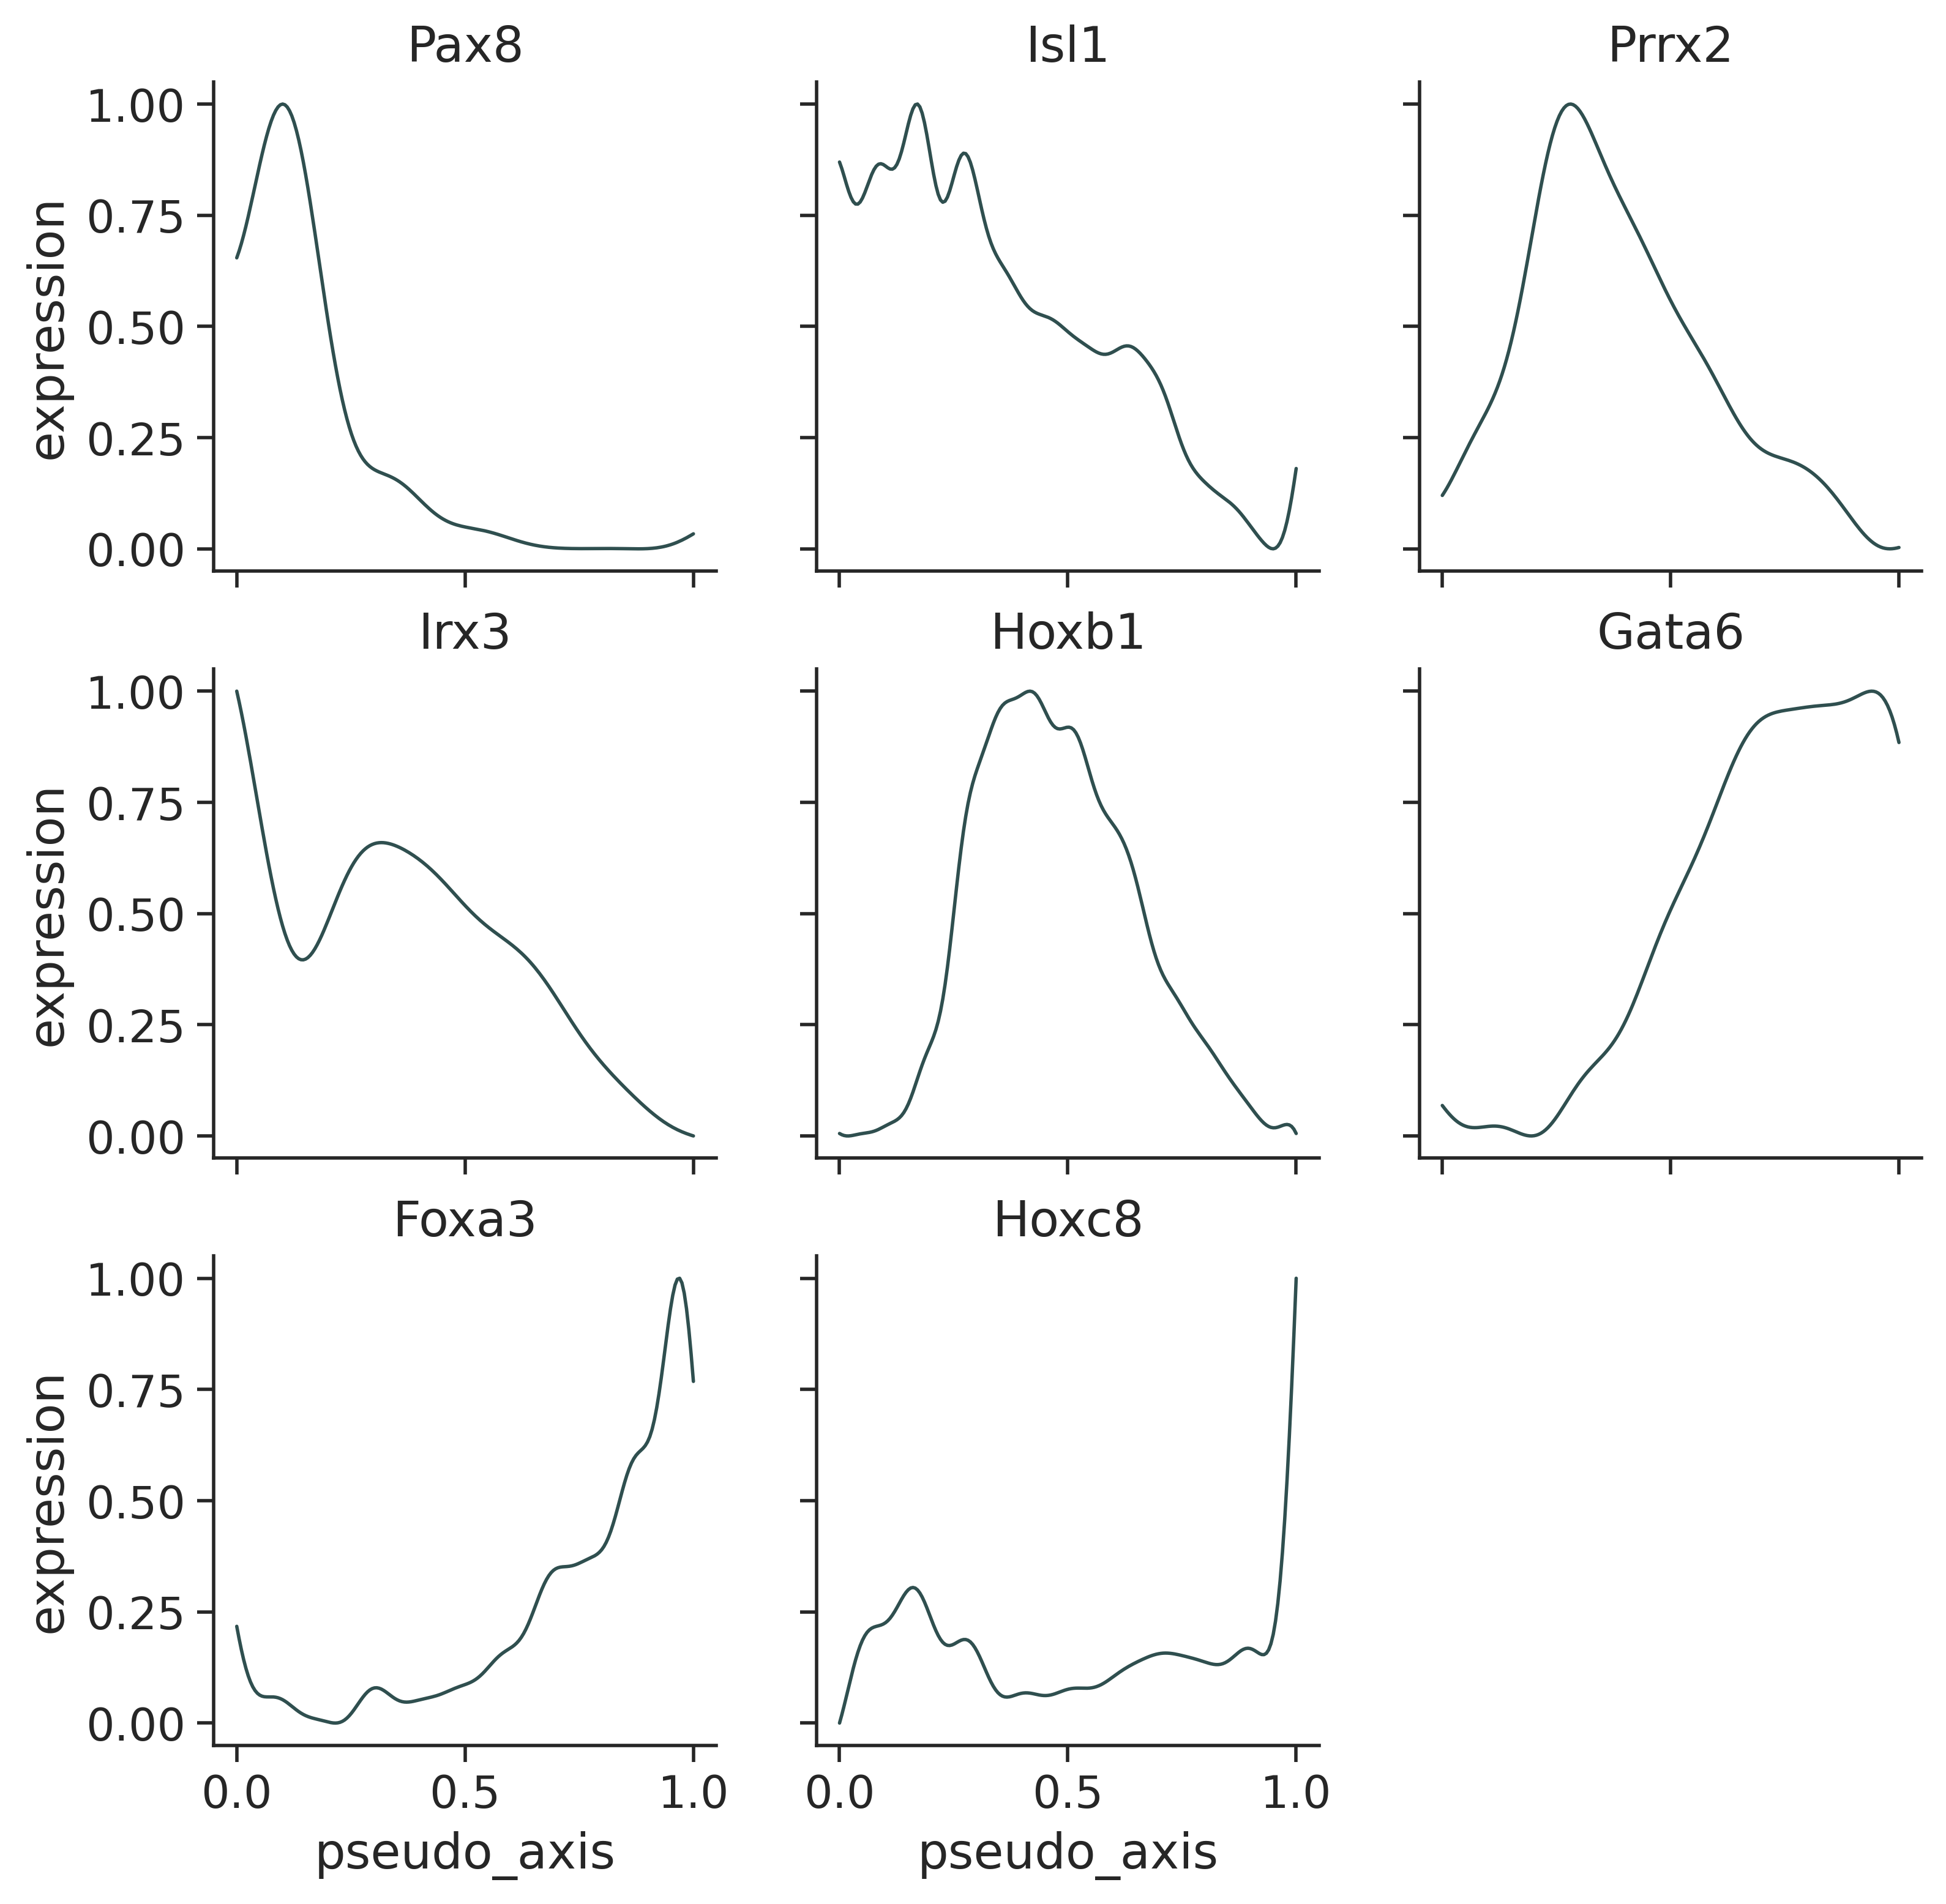

In [22]:
# plot all genes after normalization
getspan.plot.plot_reg(norm_trend, gene_set, adata, imputed_df, 'ap_dist',normalized=True)


You can also plot just one gene or a subset:

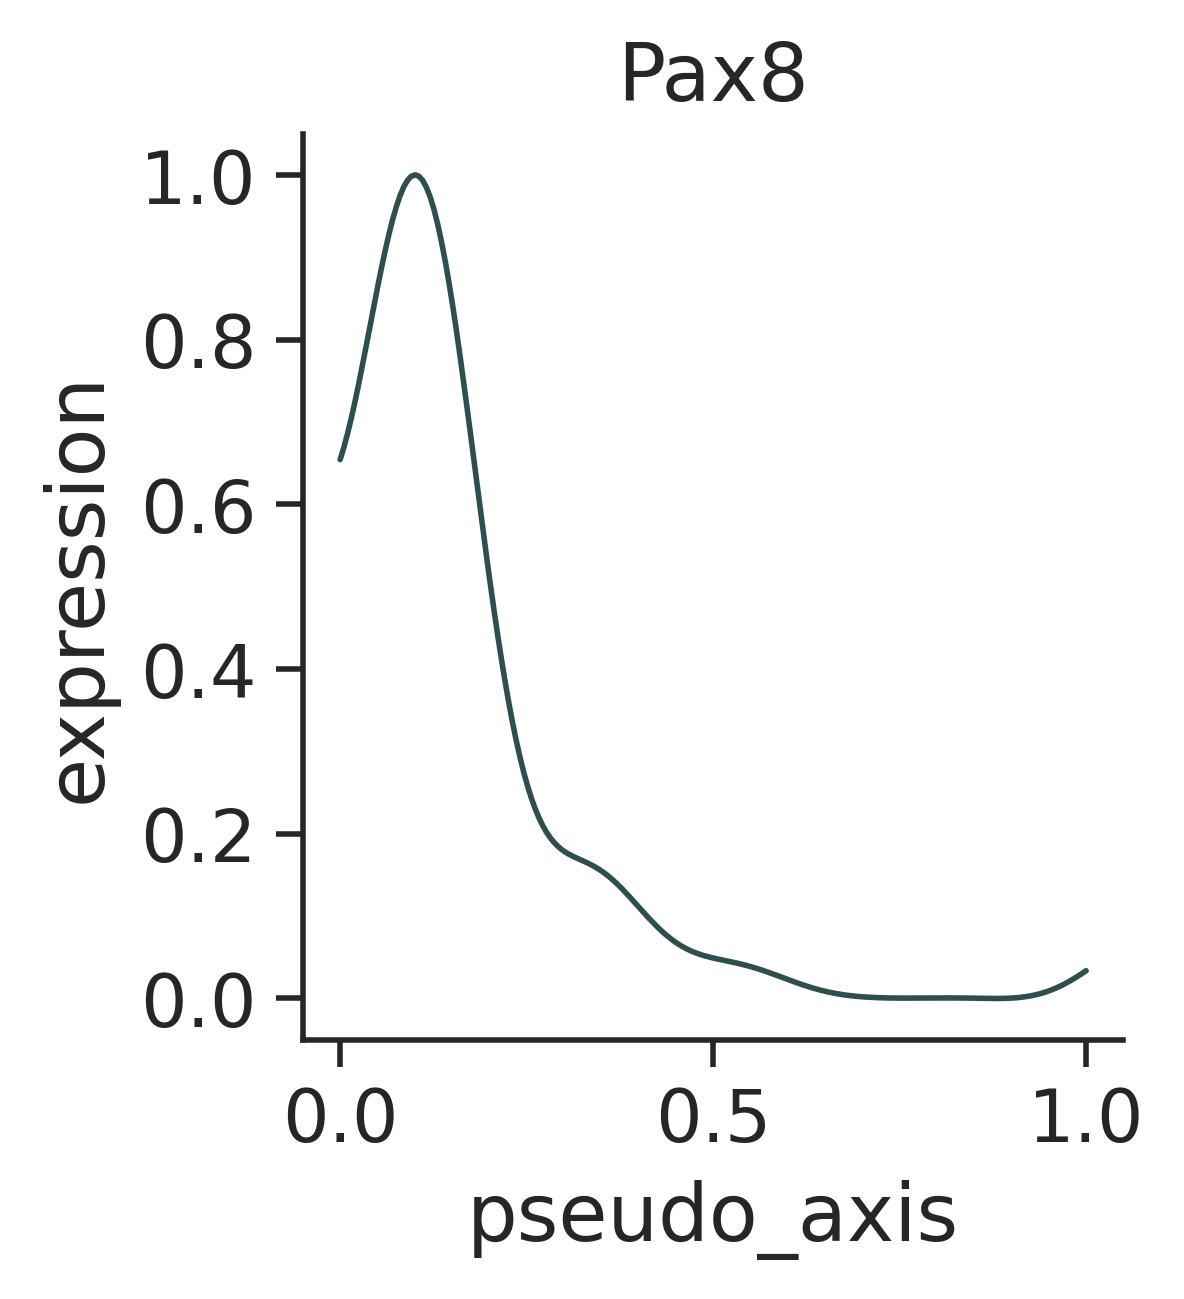

In [23]:
# Remember that the param 'genes' takes a list/array-like object
getspan.plot.plot_reg(norm_trend,[gene_set[0]], adata,imputed_df, 'ap_dist',normalized=True)

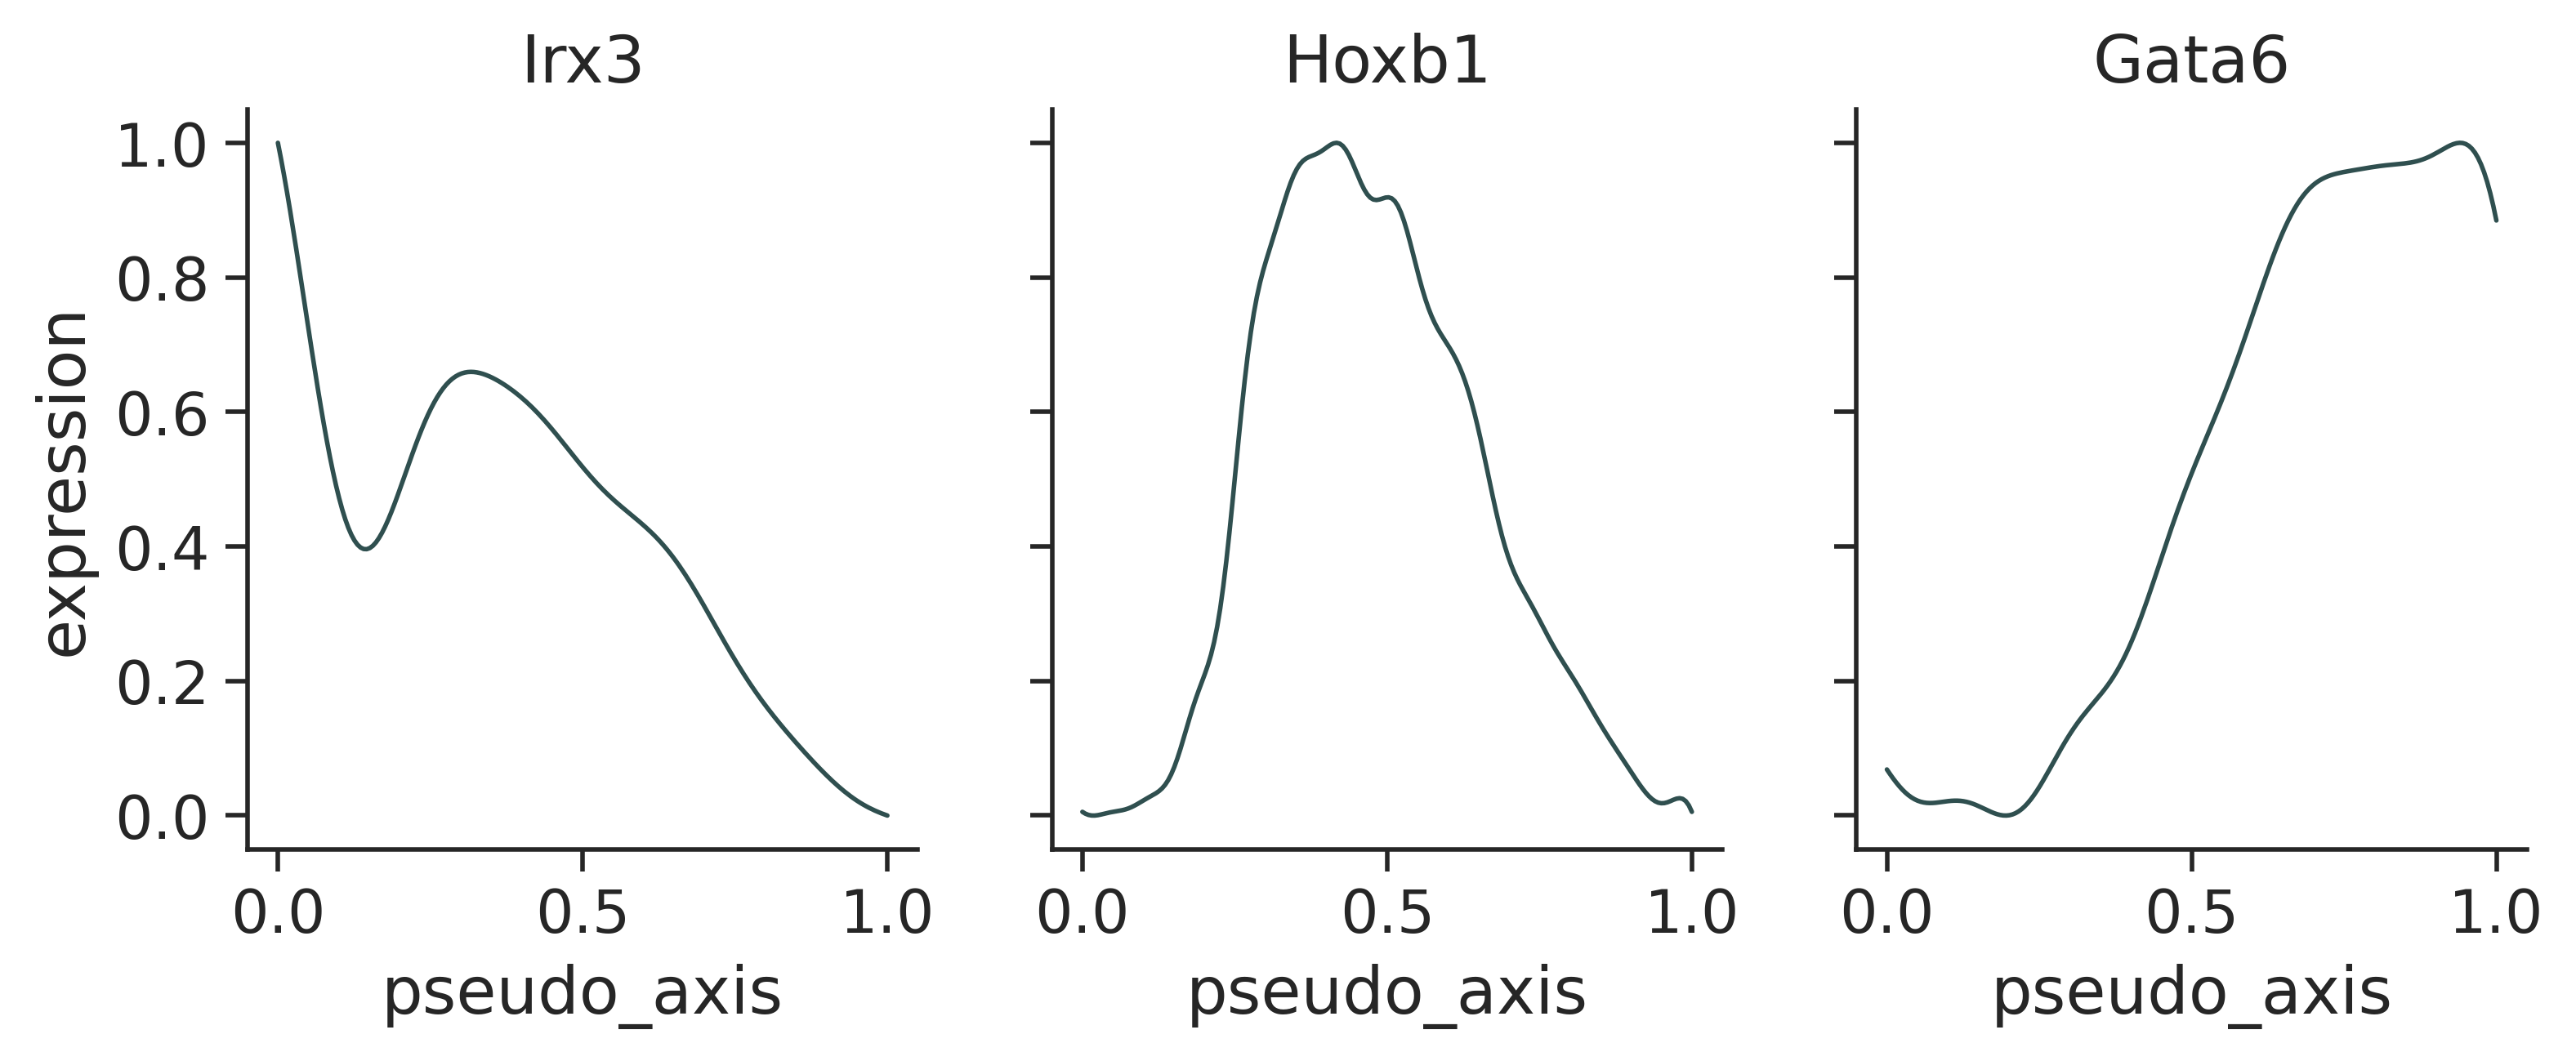

In [24]:
getspan.plot.plot_reg(norm_trend,gene_set[3:6], adata,imputed_df, 'ap_dist',normalized=True)

#### With non-normalized data

If plotting with the original, non-normalized gene trends, there are a greater variety of plots we can make. For example, we can:

1. Show the inteval of values within one standard deviation of the trend line
2. Plot the imputed expression of the indiviudal cells to check the accuracy of the GPR
3. Color the single cells by annotations in the AnnData's .obs attribute

A few examples are shown below:

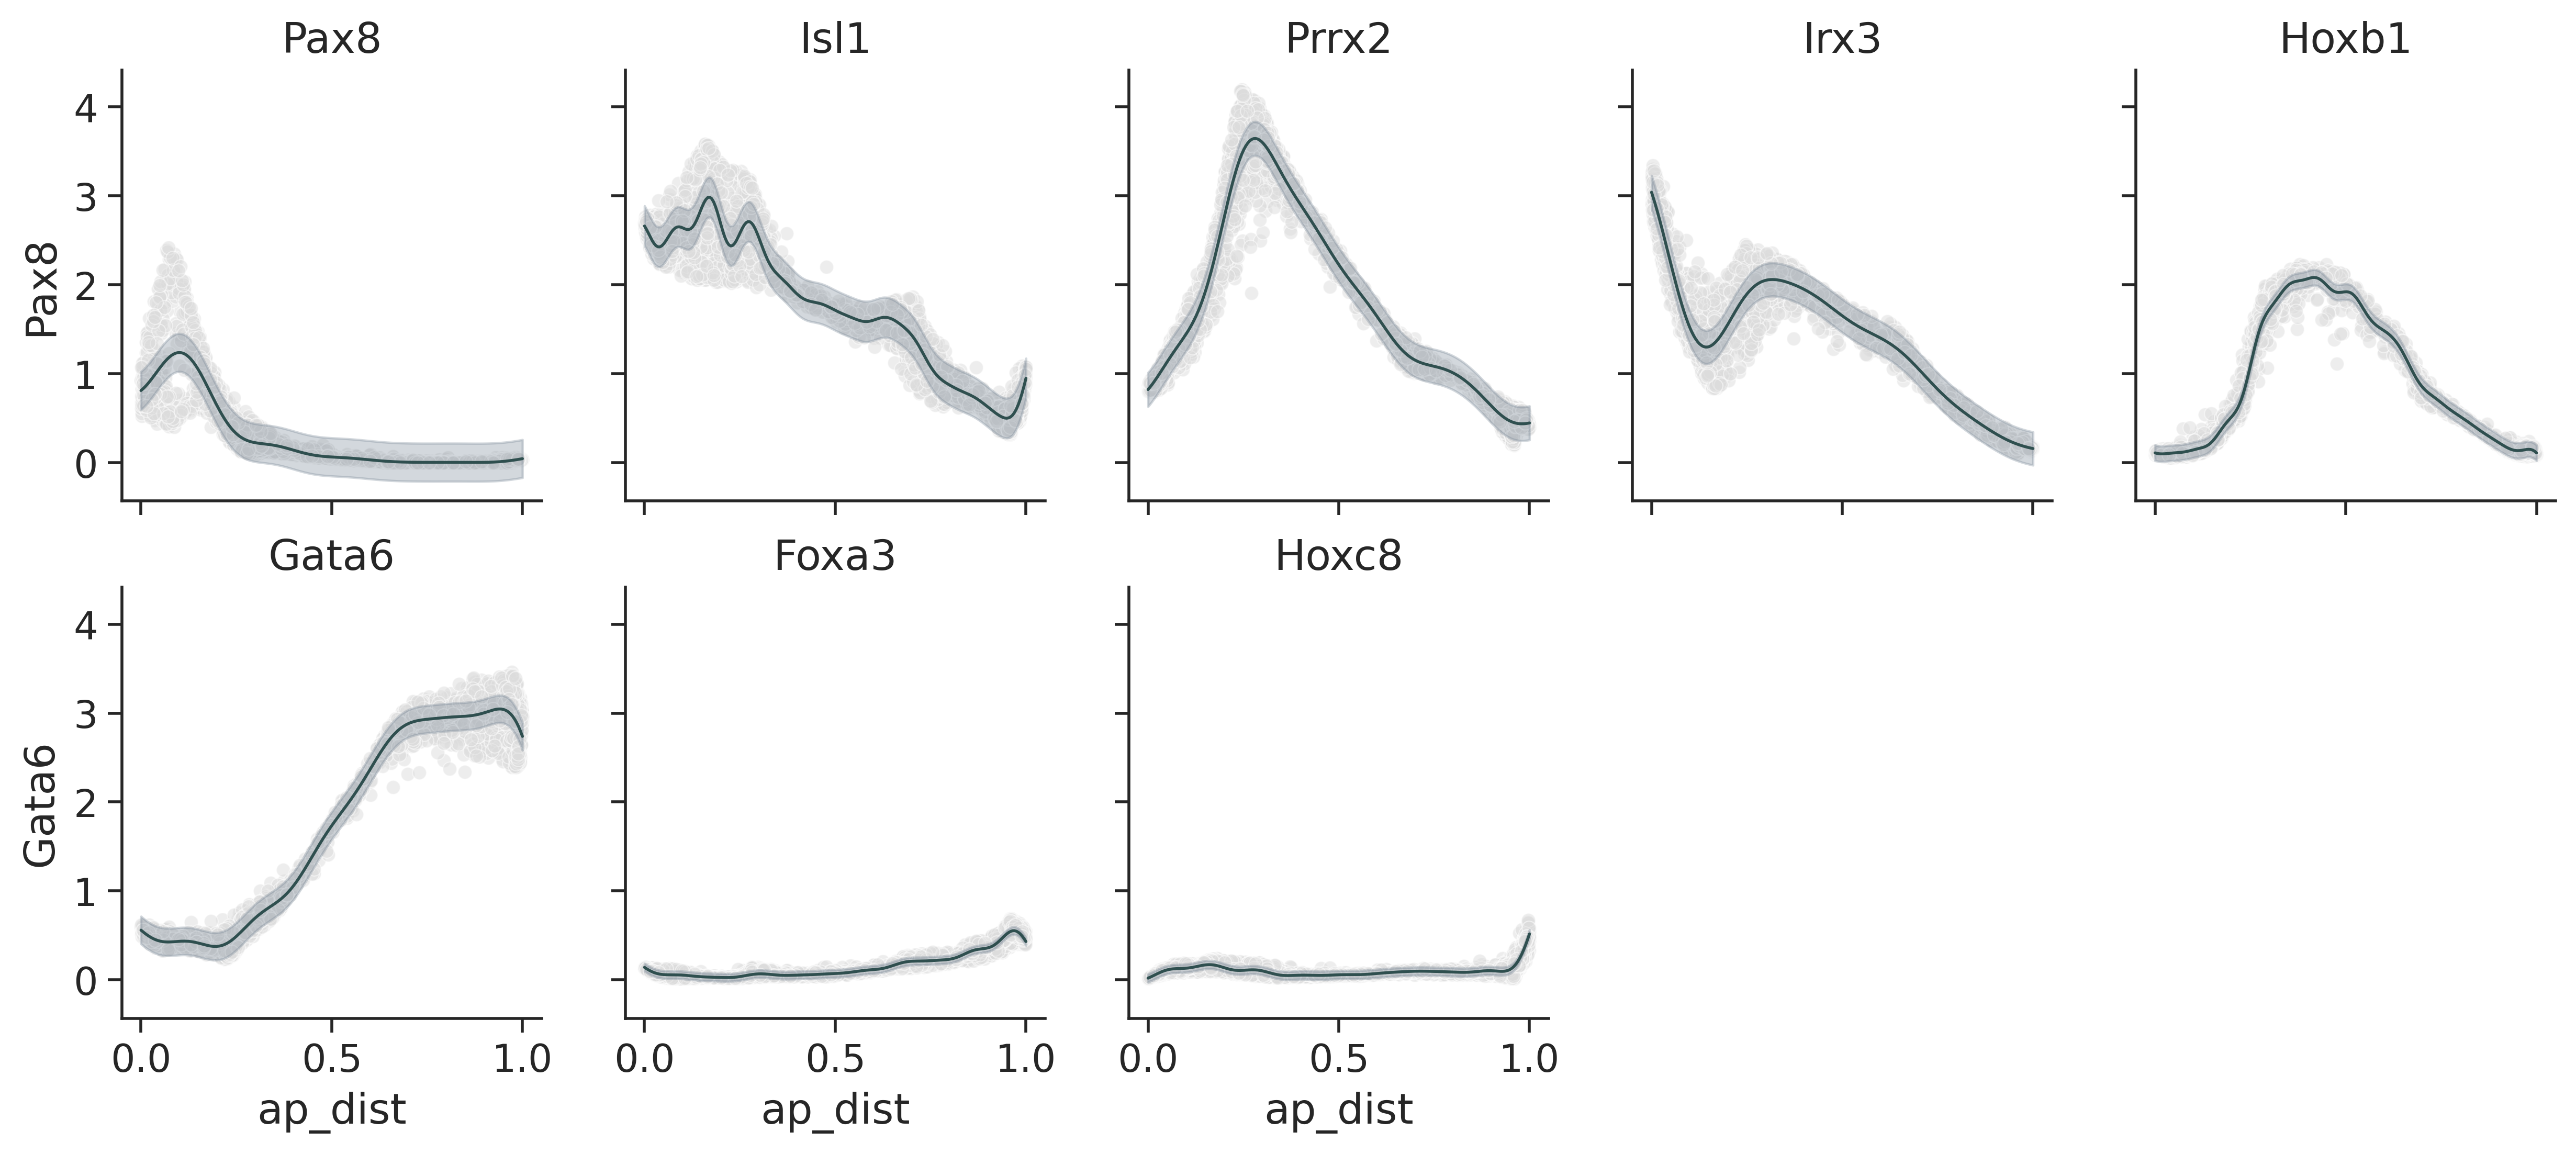

In [25]:
# without coloring the cells
# You can also change the number of columns to plot
getspan.plot.plot_reg(gene_trends, gene_set, adata, imputed_df, 'ap_dist', ncols=5)

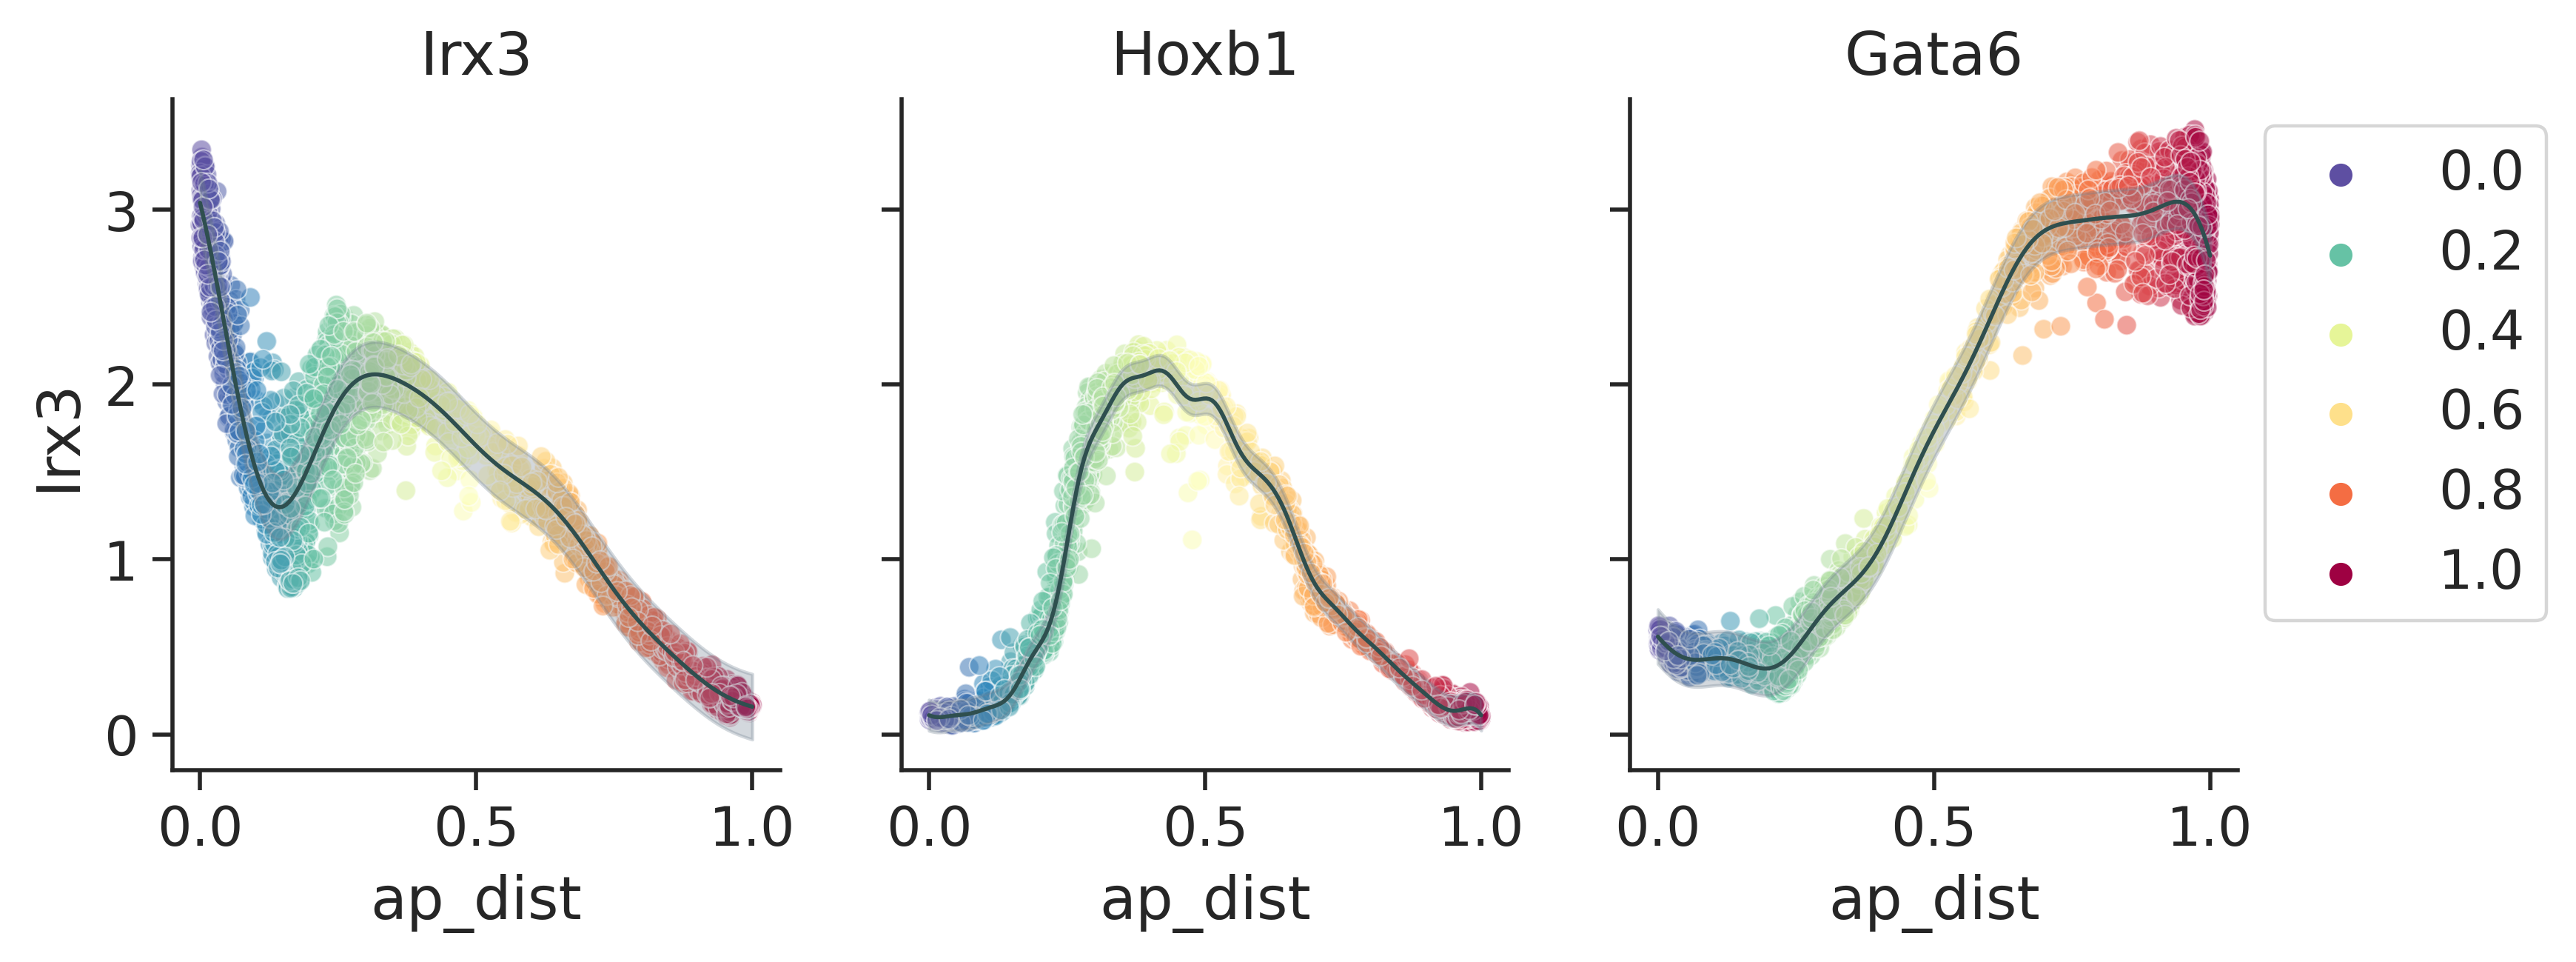

In [26]:
# coloring by value on the pseudo-axis
#    Note: am aware of the point-color legend for continuous values. Colorbar coming soon
getspan.plot.plot_reg(gene_trends, gene_set[3:6], adata, imputed_df, 'ap_dist', 
                      color_cells=True, color_by='ap_dist')


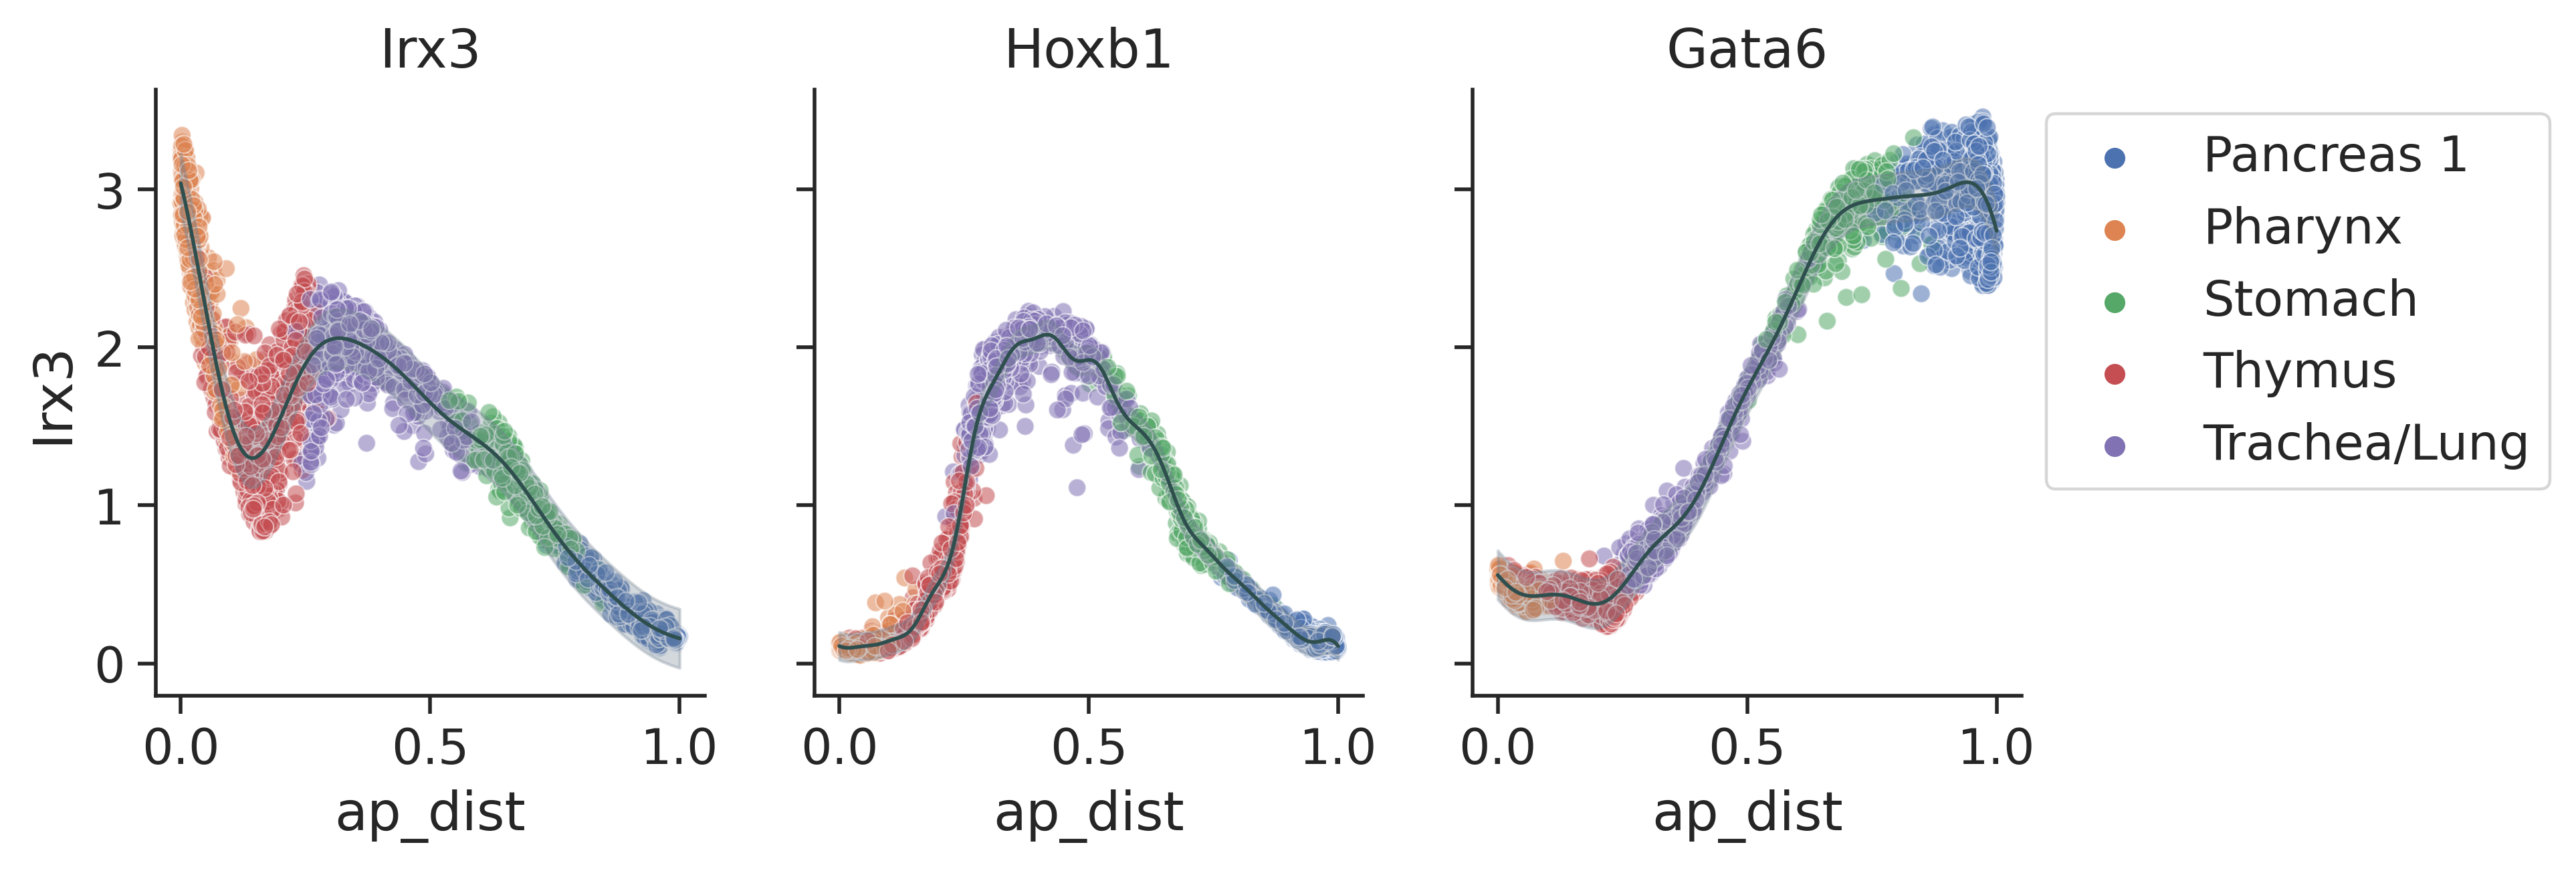

In [27]:
# coloring by cell type annotation
getspan.plot.plot_reg(gene_trends, gene_set[3:6], adata, imputed_df, 'ap_dist', 
                      color_cells=True, color_by='CellType', cpalette_key='CellType_colors')

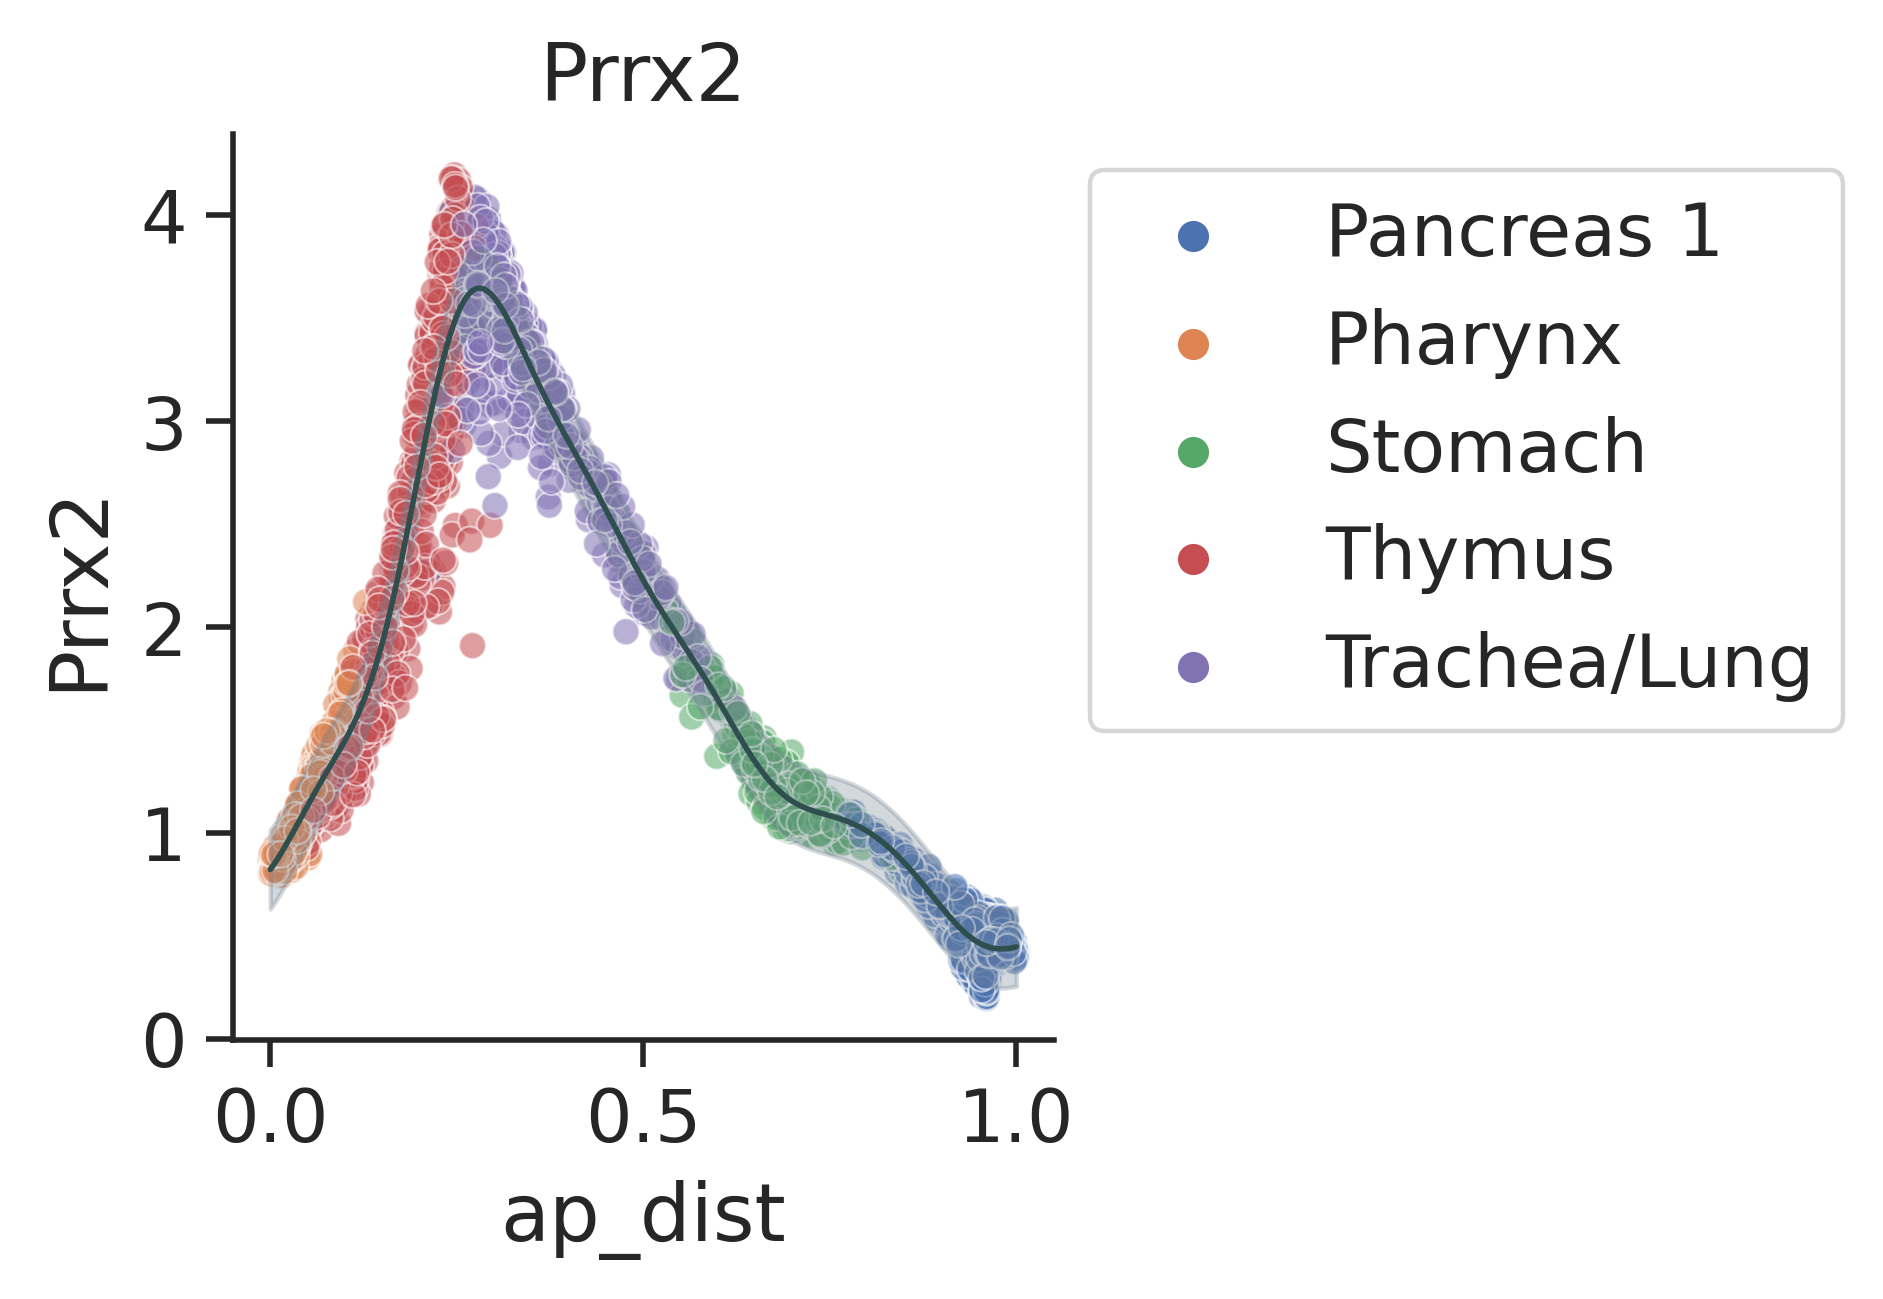

In [28]:
# demonstrating you can also plot just a single gene
getspan.plot.plot_reg(gene_trends, [gene_set[2]], adata,imputed_df, 'ap_dist', 
                      color_cells=True, color_by='CellType', cpalette_key='CellType_colors')

## Calculating span of gene expression:

Now that we have the gene trend line, we can compute the span of expression along the pseudo-axis. As noted earlier, it is recommended to compute the span off of the smoother trend line.

The non-smooth GPR can be used for visualization with the resulting span if desired

In [29]:
gene_spans = getspan.span.calc_span(smooth_gene_trends, thresh=0.2)

In [30]:
# To demonstrate below how the span changes with a higher initial threshold
gene_spans_high_thresh = getspan.span.calc_span(smooth_gene_trends, thresh=0.6)

### Visualizing gene trends

getspan's `.plot` module also contains a `plot_span` function that plots the computed gene span on the pseudo-axis with the gene trendline. Below are a few examples of the type of plots available:

#### With normalized data

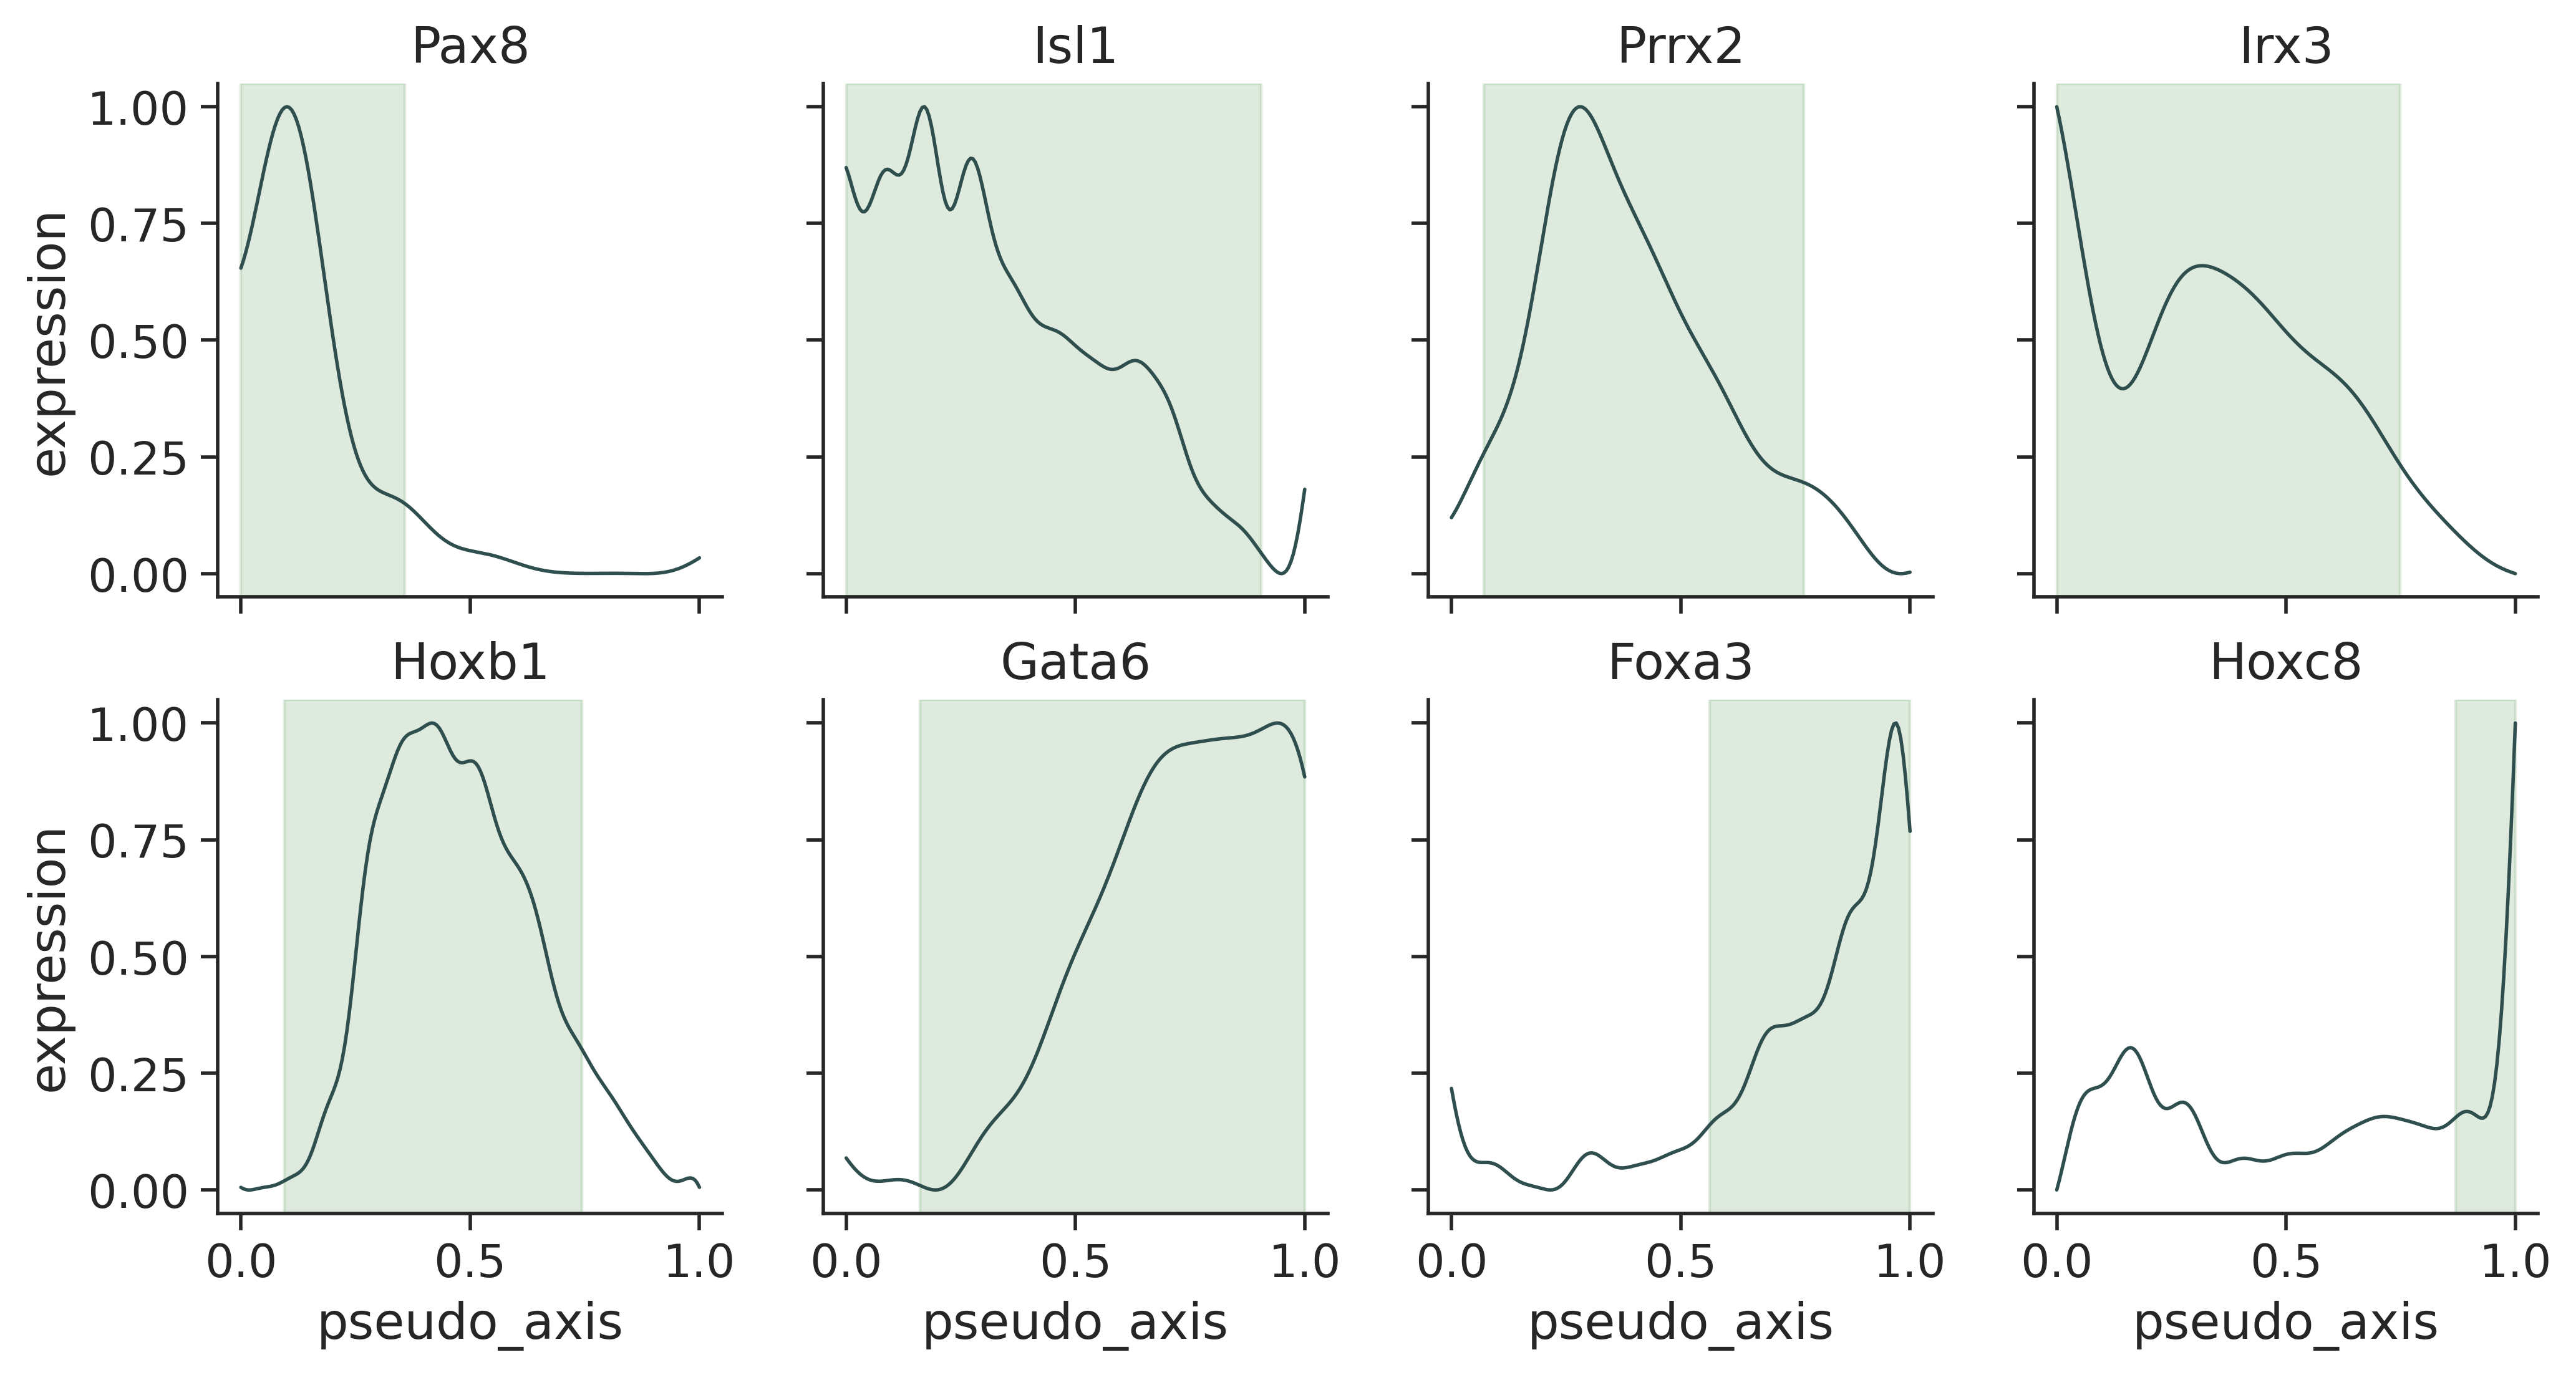

In [31]:
getspan.plot.plot_span(gene_set,gene_spans,norm_trend, ncols=4)

Since the trends are normalized prior to computing the span, it is recommended to visualize the normalized trend if plotting the intially specified threshold is desired. 
Below is an example of how the spans change when the inital threshold is changed:

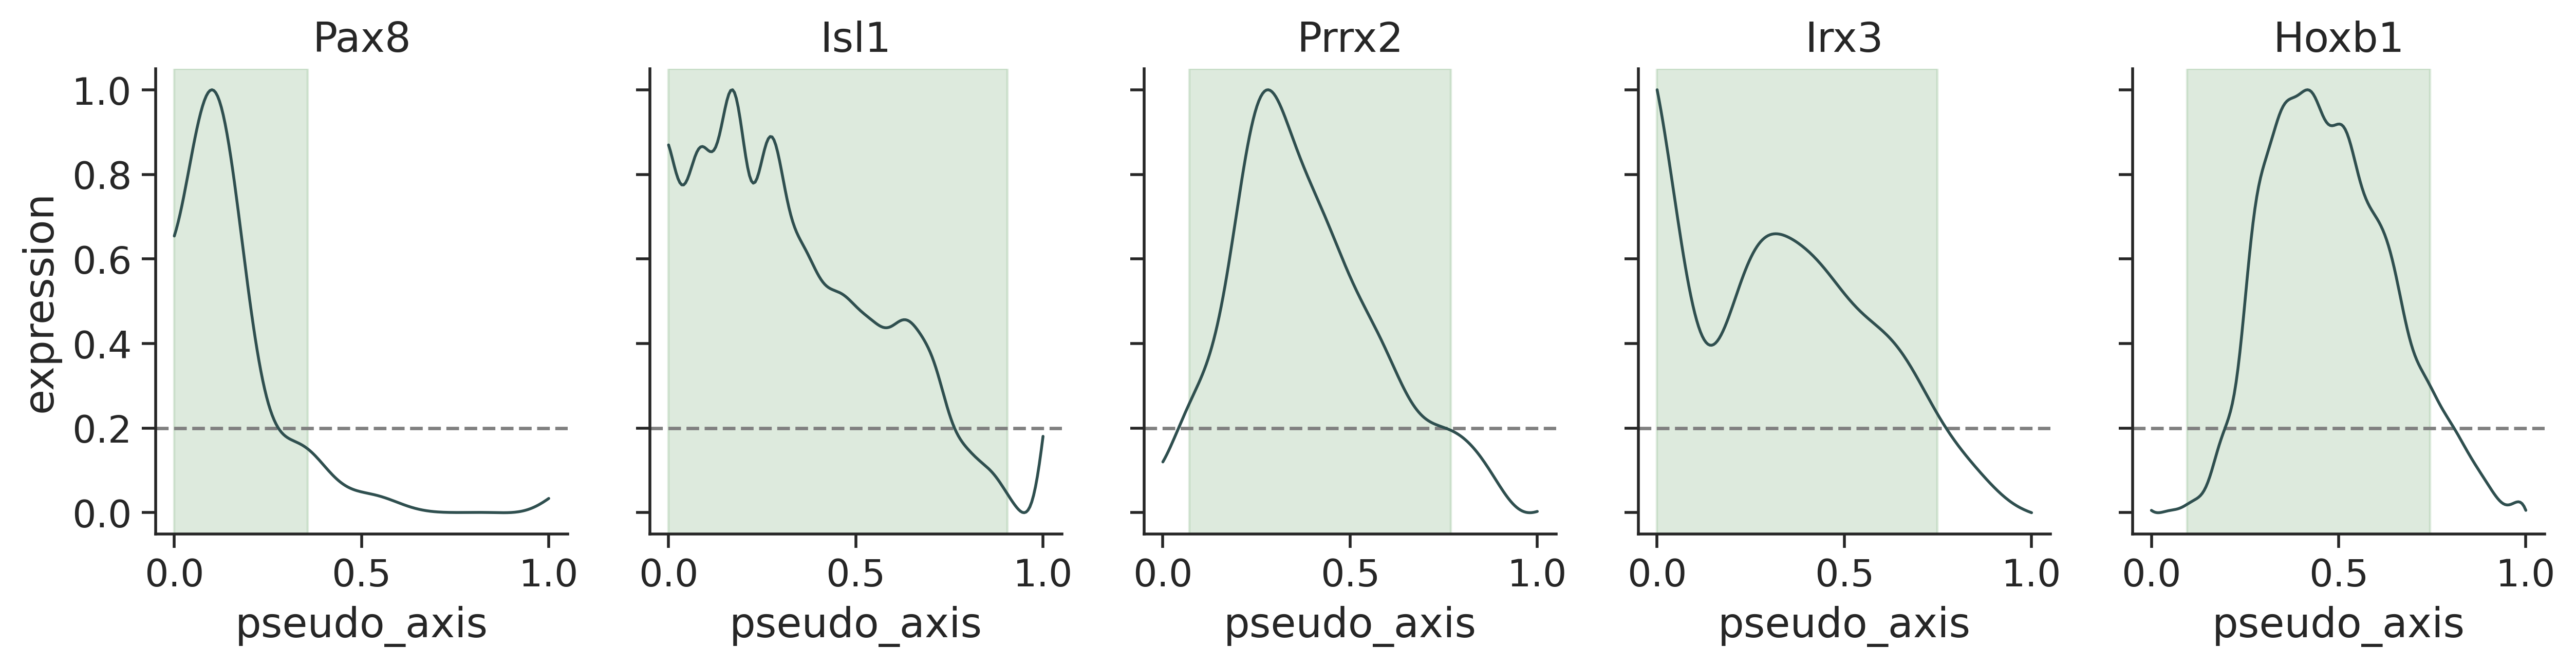

In [32]:
# Threshold = 0.2
getspan.plot.plot_span(gene_set[0:5],gene_spans,norm_trend, thresh=True, ncols=5)

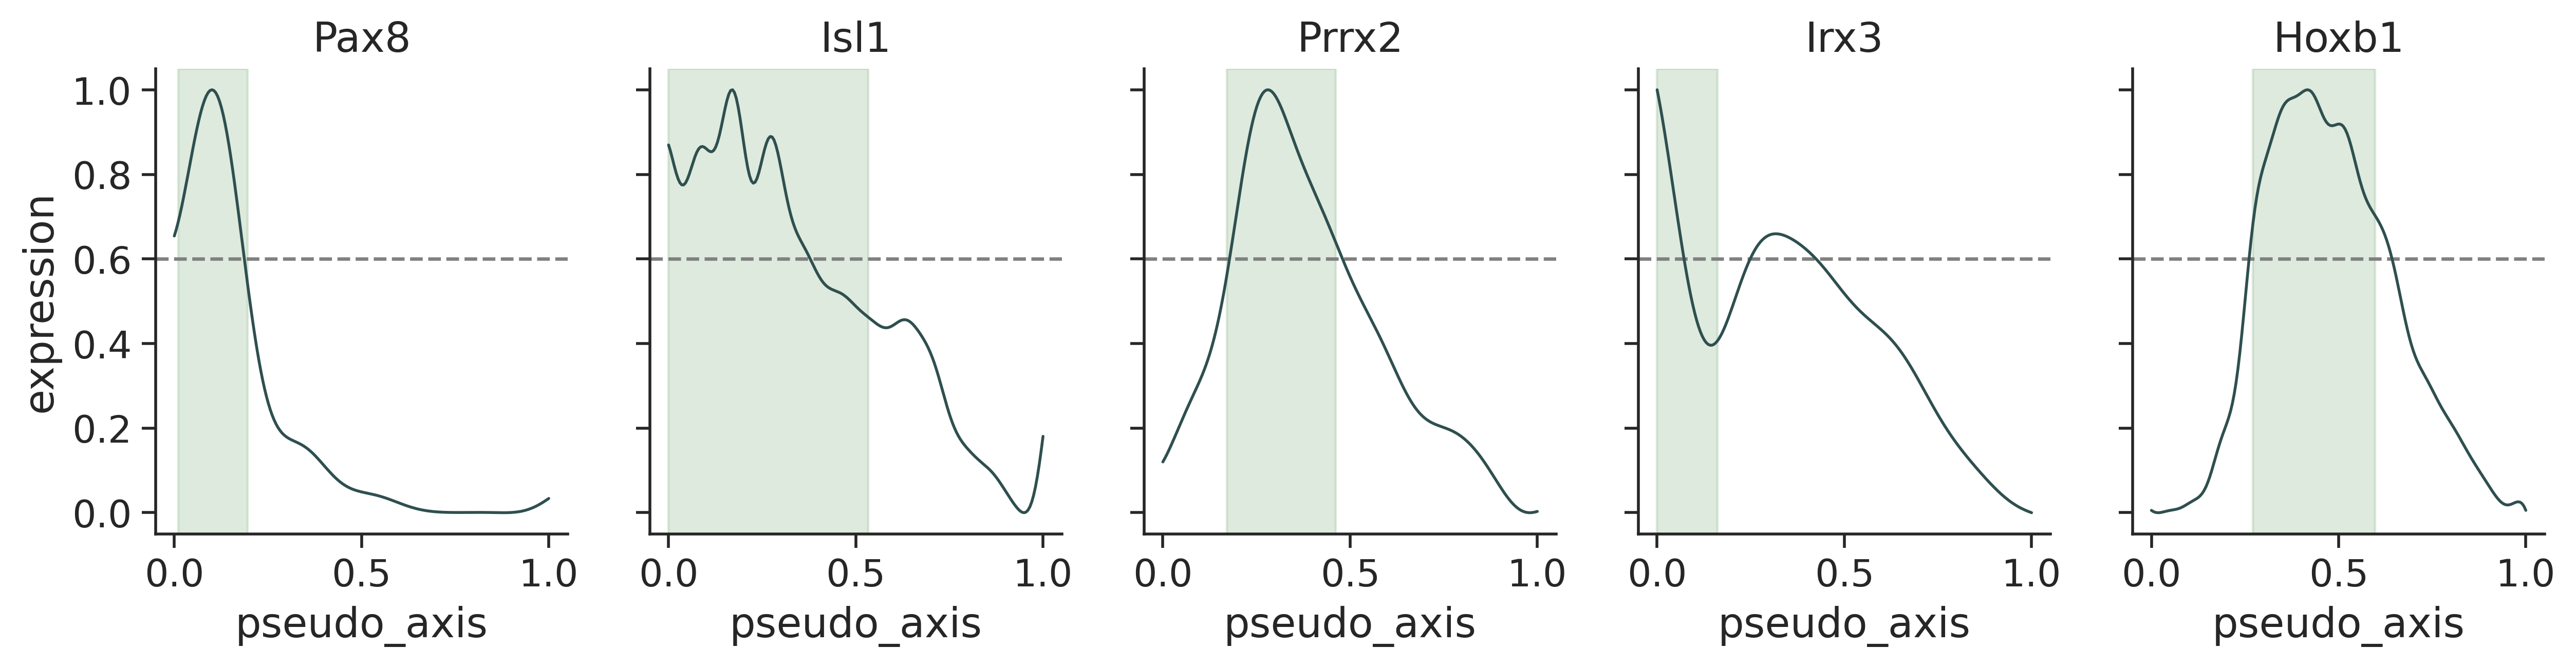

In [33]:
# Threshold = 0.6
getspan.plot.plot_span(gene_set[0:5],gene_spans_high_thresh,norm_trend, thresh=True, ncols=5)

#### With non-normalized data

If desired, the spans can also be visualized with the non-normalized trend

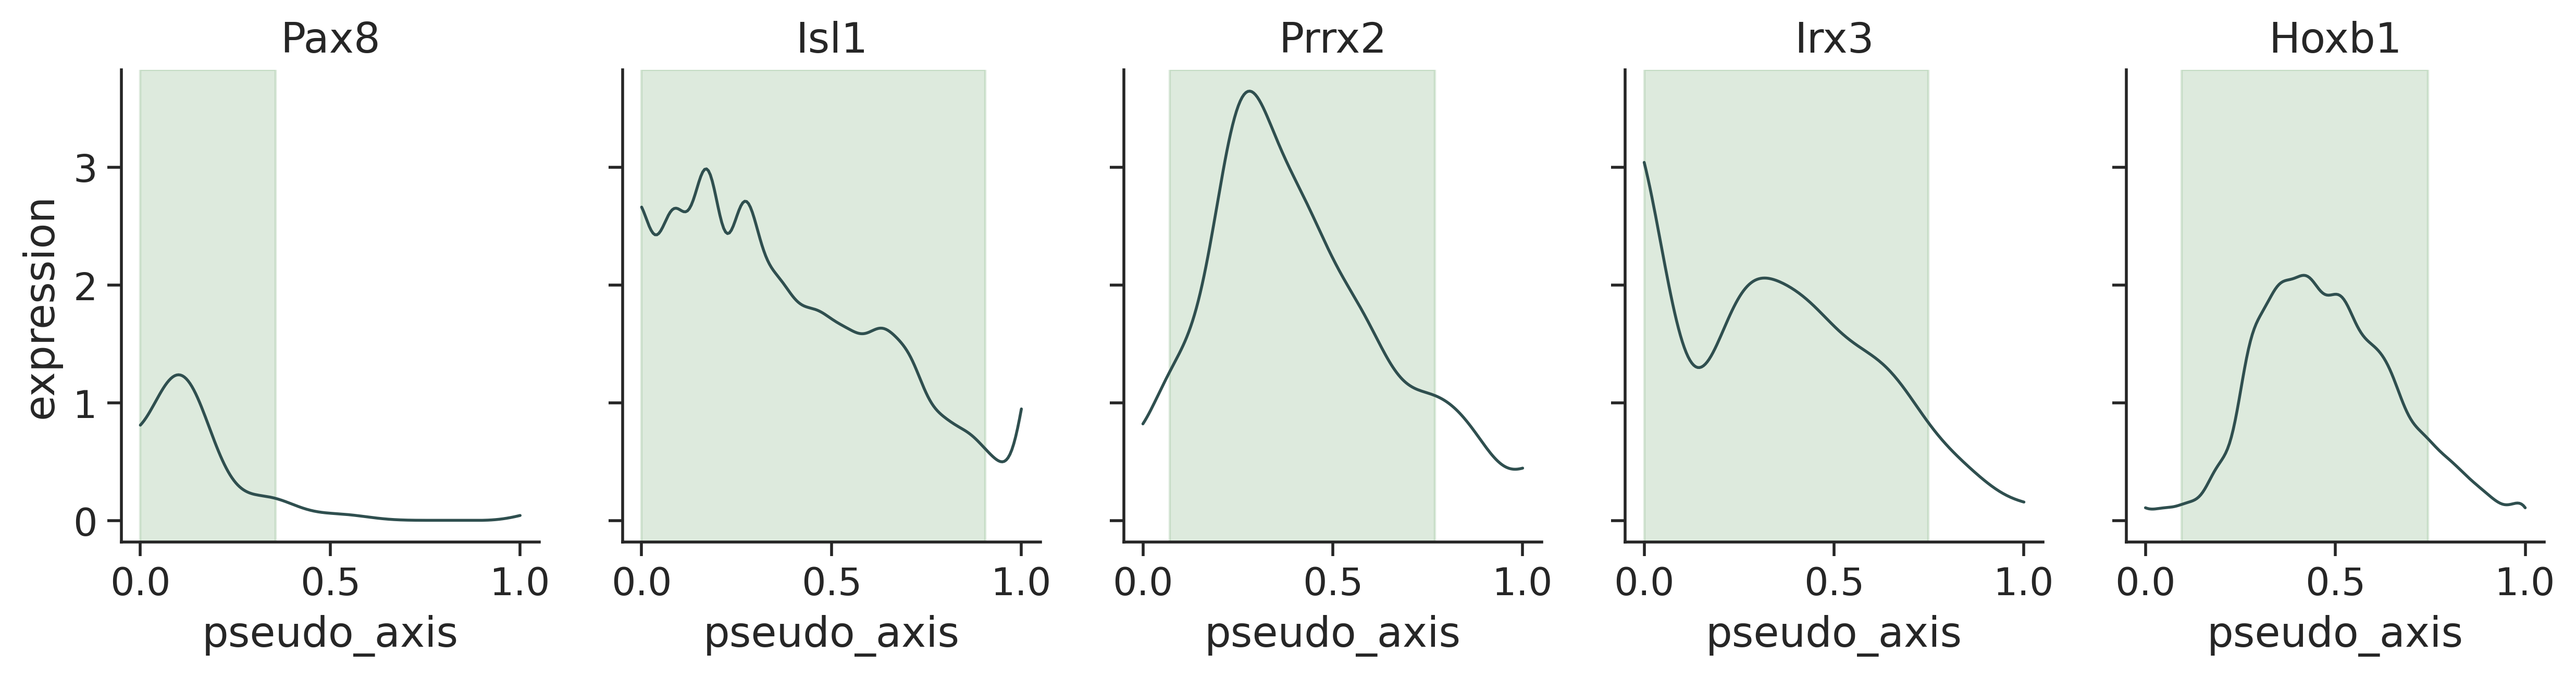

In [34]:
getspan.plot.plot_span(gene_set[0:5],gene_spans,gene_trends, ncols=5)

If desired, the inflection points of the first and second derivative used to compute the spans can be visualized. For this, it is recommended to plot the smoother trend line since it was the source:

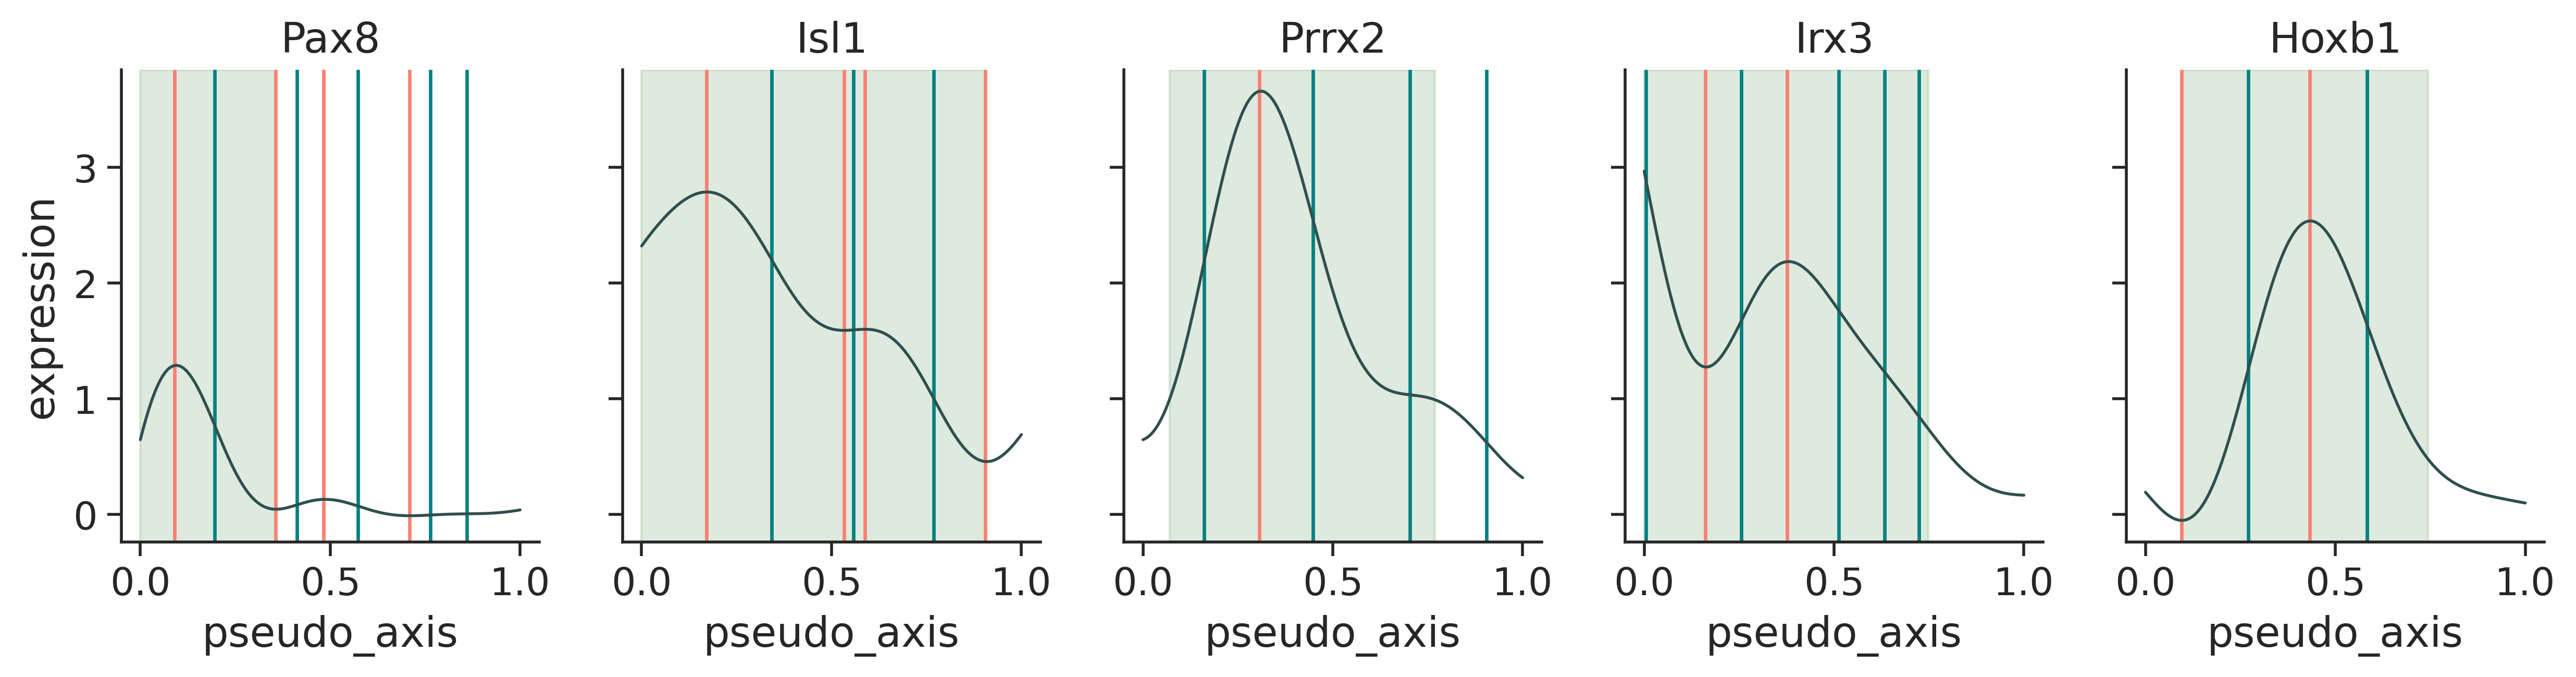

In [35]:
getspan.plot.plot_span(gene_set[0:5],gene_spans,smooth_gene_trends, inflect=True, ncols=5)